In [160]:
pip install psycopg2


Note: you may need to restart the kernel to use updated packages.


In [161]:
pip install sqlalchemy


Note: you may need to restart the kernel to use updated packages.


In [162]:
pip install clickhouse_connect

Note: you may need to restart the kernel to use updated packages.


In [163]:
pip install datetime

Note: you may need to restart the kernel to use updated packages.


In [164]:
# Импорт необходимых библиотек
import psycopg2
import clickhouse_connect
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
print('Импорт завершен')

Импорт завершен


In [165]:
import datetime

In [166]:
import sqlalchemy

In [167]:
# 1. Подключение к ClickHouse
CLICKHOUSE_CLOUD_HOSTNAME = 'come_on_dude'
CLICKHOUSE_CLOUD_USER = 'come_on_dude'
CLICKHOUSE_CLOUD_PASSWORD = 'come_on_dude'

client = clickhouse_connect.get_client(
    host=CLICKHOUSE_CLOUD_HOSTNAME, port=come_on_dude, username=CLICKHOUSE_CLOUD_USER, password=CLICKHOUSE_CLOUD_PASSWORD)

In [168]:
# 2. Подключение к PostgresSQL
engine_space = psycopg2.connect(
    dbname= 'come_on_dude',
    user='come_on_dude',
    password= 'come_on_dude',
    host= 'come_on_dude',
    port='come_on_dude')
engine_space.set_client_encoding('UTF8')
pd.options.mode.chained_assignment = None

In [169]:
# 3. Формирование датафрейма с ClientID и датой его первого визита / User_ID + первый визит

# 3.1 Запрос к Clickhouse
query_ym = 'SELECT client_id, \
                   date, \
                   visit_rang \
              FROM (SELECT CAST("ym:pv:clientID" AS text) AS client_id, \
                           "ym:pv:dateTime" AS date, \
                           ROW_NUMBER() OVER(PARTITION BY "ym:pv:clientID" \
                           ORDER BY "ym:pv:dateTime" ASC) AS visit_rang \
                     FROM masterspace.ym_logs_hits \
                    WHERE "ym:pv:clientID" != 0) AS t_1'

# 3.2 Формирование датафрейма, в колонках client_id, дата первого визита, когорта по месяцу первого визита
clickhouse = pd.DataFrame(client.query(query_ym).result_rows,columns=['client_id', 'first_visit', 'visit_rang'])
clickhouse['cohort'] = clickhouse['first_visit'].dt.strftime('%Y-%m')
clickhouse['first_visit'] = clickhouse['first_visit'].dt.normalize()
import warnings
warnings.filterwarnings('ignore')
clickhouse = clickhouse.query('first_visit >= "2024-06-01"')
clickhouse = clickhouse.query('visit_rang == 1')
clickhouse = clickhouse.drop(['visit_rang'], axis=1)

# 3.3 Запрос к PostgresSQL
query_reg = 'SELECT CAST(last_user_id AS text) AS user_id, \
                    CAST(yandex_metrika_client_id AS text) AS client_id \
               FROM public.auth_device \
              WHERE yandex_metrika_client_id IS NOT NULL'

# 3.4 Формирование датафрейма, в колонках user_id и client_id
reg = pd.read_sql(query_reg, engine_space)

# 3.5 Соединение двух датафреймов
reg = clickhouse.merge(reg, how='left', on=['client_id'])
# В датафрейме reg содержиться информация по всем client_id, первый визит на сайт которых был >= 2024-06-01

In [170]:
reg

,client_id,first_visit,cohort,user_id
0,1575635966272728,2024-07-16,2024-07,NaN
1,15719740391562802,2024-08-12,2024-08,NaN
2,15870323135955569,2024-06-06,2024-06,NaN
3,15982368782233036,2024-06-02,2024-06,NaN
4,16007180426357342,2024-07-26,2024-07,NaN
...,...,...,...,...
228820,16758434001016401563,2024-07-30,2024-07,NaN
228821,16759296871069963477,2024-07-12,2024-07,NaN
228822,16762976891032983649,2024-07-05,2024-07,5637839
228823,16766563581054318750,2024-08-03,2024-08,NaN


<Axes: xlabel='client_id'>

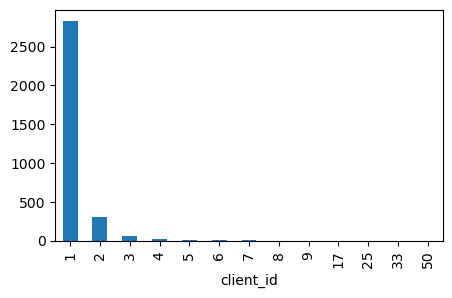

In [171]:
# 4. Проведение анализа того, сколько на одного юзера приходится client_id
user_quantity_ids = reg.copy()
user_quantity_ids = user_quantity_ids.dropna()
user_quantity_ids = user_quantity_ids.groupby('user_id')['client_id'].count() \
                                     .reset_index()
user_quantity_ids = user_quantity_ids.groupby('client_id')['user_id'].nunique() \

user_quantity_ids.plot.bar(figsize=(5 , 3))

<Axes: xlabel='user_id'>

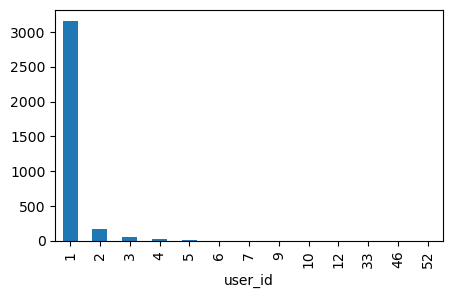

In [172]:
# 5. Проведение анализа того, сколько на один client_id приходится user_id
client_id_quantity_users = reg.copy()
client_id_quantity_users = client_id_quantity_users.dropna()
client_id_quantity_users = client_id_quantity_users.groupby('client_id')['user_id'].count() \
                                     .reset_index()
client_id_quantity_users = client_id_quantity_users.groupby('user_id')['client_id'].nunique() 
            
client_id_quantity_users.plot.bar(figsize=(5 , 3))

In [173]:
# 6. Формирование датафрейма для определения кол-ва дней от даты первого визита до регистрации
# 6.1 Формирование датафрейма с датой первого визита
users_first_visit = reg.copy()
users_first_visit = users_first_visit.dropna()
users_first_visit = users_first_visit.sort_values(['user_id', 'first_visit'], ascending=( False , True ))
users_first_visit['rang'] = users_first_visit.groupby('user_id')['first_visit'].cumcount() + 1
users_first_visit = users_first_visit.query('rang == 1')
users_first_visit.drop(['client_id', 'rang'], axis= 1 , inplace= True ) 
users_first_visit = users_first_visit[['user_id', 'cohort', 'first_visit']]

# 6.2 Формирование датафрейма с датой регистрации каждого пользователя
# 6.2.1 Запрос к PostgresSQL
query_date_reg = 'SELECT CAST(id AS text) AS user_id, \
                         created_at AS date \
                    FROM public.customer'
# 6.2.2 Формирование датафрейма, в колонках user_id и client_id
date_reg = pd.read_sql(query_date_reg, engine_space)
date_reg['reg_date'] = date_reg['date'].dt.normalize()
date_reg = date_reg.query('date >= "2024-05-01"')
date_reg = date_reg.drop(['date'], axis= 1 , inplace= False) 
# 6.2.1 Соединение двух датафреймов
date_diff = users_first_visit.merge(date_reg, how='left', on=['user_id'])
date_diff['day_diff'] = (date_diff.reg_date - date_diff.first_visit).dt.days
date_diff = date_diff.query('day_diff >= 0')
date_diff = date_diff.dropna ()

In [174]:
date_diff

,user_id,cohort,first_visit,reg_date,day_diff
0,6766291,2024-08,2024-08-18,2024-08-23,5.0
1,6764655,2024-07,2024-07-12,2024-08-23,42.0
2,6751059,2024-08,2024-08-22,2024-08-22,0.0
3,6750985,2024-08,2024-08-22,2024-08-22,0.0
4,6750669,2024-08,2024-08-11,2024-08-22,11.0
...,...,...,...,...,...
2602,5052196,2024-06,2024-06-06,2024-06-06,0.0
2603,5042347,2024-06,2024-06-03,2024-06-05,2.0
2605,5034475,2024-06,2024-06-05,2024-06-05,0.0
2618,4983119,2024-06,2024-06-01,2024-06-01,0.0


In [175]:
# 7 Визуализация кол-ва пользователей в каждой группе (кол-во дней до регистрации) ТОП 20

In [176]:
date_diff_group = date_diff.copy()
date_diff_group = date_diff_group.groupby('day_diff')['user_id'].count()
date_diff_group.head(20)

day_diff
0.0     2183
1.0       46
2.0       43
3.0       17
4.0       16
5.0       20
6.0       10
7.0       12
8.0        6
9.0        8
10.0       5
11.0      11
12.0       5
13.0       7
14.0       3
15.0       6
16.0       2
17.0       6
18.0       5
19.0       1
Name: user_id, dtype: int64

<Axes: xlabel='day_diff'>

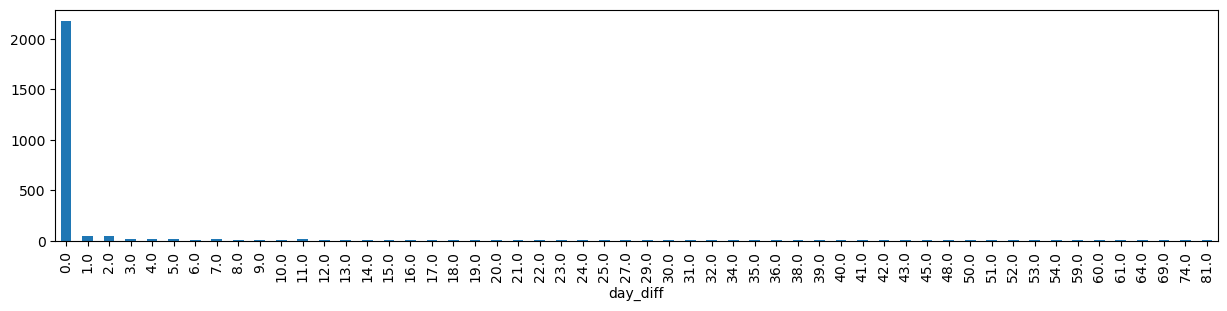

In [177]:
date_diff_group.plot.bar(figsize=(15 , 3))

In [178]:
# 8 Расчет среднего кол-во дней от первого визита до регистрации по когортам (месяц первого визита)
date_diff_avg =  date_diff.copy()
date_diff_avg = date_diff_avg.groupby('cohort').agg({'day_diff':'mean'}).round(1).reset_index()
date_diff_avg

,cohort,day_diff
0,2024-06,3.1
1,2024-07,0.9
2,2024-08,0.3


In [179]:
# 9 Расчет основных показателей юнит-экономики по когортам (месяц первого визита)

# Показатель конверсии везде абсолютный, т.е рассчитан от первого шага воронки

# 9.1 Формирование столбца с кол-вом пользователей по данным Я.Метрики
unit_cohort_users = reg.copy()
unit_cohort_users
unit_cohort_users = unit_cohort_users.groupby('cohort').agg({'client_id':'count'}).reset_index()
unit_ecomomics = unit_cohort_users.merge(date_diff_avg, how='left', on=['cohort'])

# 9.2 Формирование столбца с кол-вом зарегистрированных пользователей и конверсией из пользователей в зарегистрированного пользователя
unit_cohort_users_space = reg.copy()
unit_cohort_users_space = unit_cohort_users_space.dropna()
unit_cohort_users_space = unit_cohort_users_space.groupby('cohort').agg({'user_id':'count'}).reset_index()
unit_ecomomics = unit_ecomomics.merge(unit_cohort_users_space, how='left', on=['cohort'])
unit_ecomomics['cr_visit_reg'] = (unit_ecomomics.user_id * 100 / unit_ecomomics.client_id).round(2)

# 9.3 Формирование столбца с кол-вом пользователей создавших мероприятие и конверсией из пользователя в пользователя создавшего 1-е мероприятие
unit_cohort_users_space_events = 'SELECT CAST(owner_id AS text) AS user_id, \
                                         CAST(id AS text) AS event_id, \
                                         created_at \
                                   FROM public.treatment \
                                  UNION \
                                 SELECT CAST(customer_id AS text) AS user_id, \
                                        CAST(id AS text) AS event_id, \
                                        created_at \
                                  FROM public.promotion_treatment_stock \
                                 UNION \
                                SELECT CAST(owner_id AS text) AS user_id, \
                                       CAST(treatment_id AS text) AS event_id, \
                                       created_at \
                                 FROM public.promotion_treatment_history'
unit_cohort_users_space_events = pd.read_sql(unit_cohort_users_space_events, engine_space)
unit_cohort_users_space_events = unit_cohort_users_space_events.sort_values(['created_at'], ascending=(True ))
unit_cohort_users_space_events['rang'] = unit_cohort_users_space_events.groupby('user_id')['created_at'].cumcount() + 1
unit_cohort_users_space_events = unit_cohort_users_space_events.query('rang == 1')
unit_cohort_users_space_events['cohort'] = unit_cohort_users_space_events['created_at'].dt.strftime('%Y-%m')
unit_cohort_users_space_events = unit_cohort_users_space_events.query('created_at >= "2024-06-01"')
unit_cohort_users_space_events = unit_cohort_users_space_events.drop(['created_at', 'event_id', 'rang'], axis= 1 , inplace= False) 
unit_cohort_users_space_events = unit_cohort_users_space_events.groupby('cohort').agg({'user_id':'count'}).reset_index()
unit_cohort_users_space_events = unit_cohort_users_space_events.rename(columns = {"user_id": "events"})
unit_ecomomics = unit_ecomomics.merge(unit_cohort_users_space_events, how='left', on=['cohort'])
unit_cohort_users_space_events = unit_cohort_users_space_events.rename(columns = {"user_id": "events"})
unit_ecomomics['cr_visit_event'] = (unit_ecomomics.events * 100 / unit_ecomomics.client_id).round(2)

# 9.4 Формирование столбца с кол-вом пользователей создавших статью и конверсией из пользователя в пользователя создавшего 1-ю статью
unit_cohort_users_space_articles = 'SELECT CAST(owner_id AS text) AS user_id, \
                                           CAST(id AS text) AS article_id, \
                                           created_at \
                                     FROM public.article'
unit_cohort_users_space_articles = pd.read_sql(unit_cohort_users_space_articles, engine_space)
unit_cohort_users_space_articles = unit_cohort_users_space_articles.sort_values(['created_at'], ascending=(True ))
unit_cohort_users_space_articles['rang'] = unit_cohort_users_space_articles.groupby('user_id')['created_at'].cumcount() + 1
unit_cohort_users_space_articles = unit_cohort_users_space_articles.query('rang == 1')
unit_cohort_users_space_articles['cohort'] = unit_cohort_users_space_articles['created_at'].dt.strftime('%Y-%m')
unit_cohort_users_space_articles = unit_cohort_users_space_articles.query('created_at >= "2024-06-01"')
unit_cohort_users_space_articles = unit_cohort_users_space_articles.drop(['created_at', 'article_id', 'rang'], axis= 1 , inplace= False) 
unit_cohort_users_space_articles = unit_cohort_users_space_articles.groupby('cohort').agg({'user_id':'count'}).reset_index()
unit_cohort_users_space_articles = unit_cohort_users_space_articles.rename(columns = {"user_id": "articles"})
unit_ecomomics = unit_ecomomics.merge(unit_cohort_users_space_articles, how='left', on=['cohort'])
unit_ecomomics['cr_visit_article'] = (unit_ecomomics.articles * 100 / unit_ecomomics.client_id).round(2)

# 9.5 Формирование столбца с кол-вом пользователей с бронированием и конверсией из пользователя в пользователя, которые сделал 1-ое бронирвоание
unit_cohort_users_space_booking = 'SELECT CAST(customer_id AS text) AS user_id, \
                                           CAST(treatment_id AS text) AS booking_id, \
                                           created_at \
                                      FROM public.booking_treatment'
unit_cohort_users_space_booking = pd.read_sql(unit_cohort_users_space_booking, engine_space)
unit_cohort_users_space_booking = unit_cohort_users_space_booking.sort_values(['created_at'], ascending=(True ))
unit_cohort_users_space_booking['rang'] = unit_cohort_users_space_booking.groupby('user_id')['created_at'].cumcount() + 1
unit_cohort_users_space_booking = unit_cohort_users_space_booking.query('rang == 1')
unit_cohort_users_space_booking['cohort'] = unit_cohort_users_space_booking['created_at'].dt.strftime('%Y-%m')
unit_cohort_users_space_booking = unit_cohort_users_space_booking.query('created_at >= "2024-06-01"')
unit_cohort_users_space_booking = unit_cohort_users_space_booking.drop(['created_at', 'booking_id', 'rang'], axis= 1 , inplace= False) 
unit_cohort_users_space_booking = unit_cohort_users_space_booking.groupby('cohort').agg({'user_id':'count'}).reset_index()
unit_cohort_users_space_booking = unit_cohort_users_space_booking.rename(columns = {"user_id": "bookings"})
unit_ecomomics = unit_ecomomics.merge(unit_cohort_users_space_booking, how='left', on=['cohort'])
unit_ecomomics['cr_visit_booking'] = (unit_ecomomics.bookings * 100 / unit_ecomomics.client_id).round(2)
# 9.6 Формирование столбца с кол-вом пользователей с бронированием и конверсией из пользователя в пользователя, которые сделал 1-ое бронирвоание
# за исключением экспертов
unit_cohort_users_space_booking_clean = 'SELECT CAST(customer_id AS text) AS user_id, \
                                                CAST(treatment_id AS text) AS booking_id_clean, \
                                                created_at \
                                          FROM public.booking_treatment \
                                         WHERE CAST(customer_id AS text) NOT IN \
                                         (SELECT DISTINCT(id) AS customer_id \
                                            FROM (SELECT id \
                                                    FROM (SELECT CAST(owner_id AS text) AS id \
                                                            FROM public.specialist ) AS t_1 \
                                           UNION \
                                          SELECT id \
                                            FROM (SELECT CAST(owner_id AS text) AS id \
                                                    FROM public.company) AS t_2\
                                           UNION \
                                          SELECT id \
                                            FROM (SELECT CAST(owner_id AS text) AS id \
                                                    FROM public.article) AS t_3 \
                                           UNION \
                                          SELECT id \
                                            FROM (SELECT CAST(owner_id AS text) AS id \
                                                    FROM public.treatment) AS t_4 \
                                           UNION \
                                          SELECT id \
                                            FROM (SELECT CAST(owner_id AS text) AS id \
                                            FROM public.promotion_treatment_history) AS t_5) AS t_6)' 
unit_cohort_users_space_booking_clean = pd.read_sql(unit_cohort_users_space_booking_clean, engine_space)
unit_cohort_users_space_booking_clean = unit_cohort_users_space_booking_clean.sort_values(['created_at'], ascending=(True ))
unit_cohort_users_space_booking_clean['rang'] = unit_cohort_users_space_booking_clean.groupby('user_id')['created_at'].cumcount() + 1
unit_cohort_users_space_booking_clean = unit_cohort_users_space_booking_clean.query('rang == 1')
unit_cohort_users_space_booking_clean['cohort'] = unit_cohort_users_space_booking_clean['created_at'].dt.strftime('%Y-%m')
unit_cohort_users_space_booking_clean = unit_cohort_users_space_booking_clean.query('created_at >= "2024-06-01"')
unit_cohort_users_space_booking_clean = unit_cohort_users_space_booking_clean.drop(['created_at', 'booking_id_clean', 'rang'], 
                                                                                     axis= 1 , inplace= False) 
unit_cohort_users_space_booking_clean = unit_cohort_users_space_booking_clean.groupby('cohort').agg({'user_id':'count'}).reset_index()
unit_cohort_users_space_booking_clean = unit_cohort_users_space_booking_clean.rename(columns = {"user_id": "bookings_clean"})
unit_ecomomics = unit_ecomomics.merge(unit_cohort_users_space_booking_clean, how='left', on=['cohort'])
unit_ecomomics['cr_visit_booking_clean'] = (unit_ecomomics.bookings_clean * 100 / unit_ecomomics.client_id).round(2)

# Расшифровка названий колонок в результирующей таблице
###                 cohort - год и месяц когорты (формируется по дате первого визита пользователя на платформу)
###              client_id - кол-во уникальных пользвоателей на основе данных Яндекс.Метрики
###               day_diff - кол-во дней между первым посещением и регистрацией
###                user_id - кол-во зарегистрированных пользователей
###           cr_visit_reg - конверсия из пользователя в зарегистрированного пользователя
###                 events - кол-во созданных мероприятий (только мероприятия, которые создали впервые)
###         cr_visit_event - конверсия из пользователя в пользователя, создавшего 1-е мероприятие
###                 events - кол-во созданных статей (только статьи, которые создали впервые)
###       cr_visit_article - конверсия из пользователя в пользователя, создавшего 1-ю статью
###               bookings - кол-во бронирований (только бронирвоания, которые были впервые)
###       cr_visit_booking - конверсия из пользователя в пользователя, забронировавшего мероприятие
###         bookings_clean - кол-во бронирований, в которых нет экспертов
### cr_visit_booking_clean - конверсия из пользователя, забронировавшего мероприятие (без экспертов)
unit_ecomomics

,cohort,client_id,day_diff,user_id,cr_visit_reg,events,cr_visit_event,articles,cr_visit_article,bookings,cr_visit_booking,bookings_clean,cr_visit_booking_clean
0,2024-06,77123,3.1,1507,1.95,153,0.20,17,0.02,117,0.15,107,0.14
1,2024-07,84483,0.9,1512,1.79,133,0.16,10,0.01,99,0.12,95,0.11
2,2024-08,67219,0.3,1001,1.49,109,0.16,14,0.02,75,0.11,70,0.10


In [180]:
# 10 Расчет усредненных показателей юнит-экономики

unit_ecomomics_avg = unit_ecomomics.copy()
unit_ecomomics_avg = unit_ecomomics_avg.agg({"client_id": "mean", 
                        "cr_visit_reg": "mean", 
                        "cr_visit_event": "mean", 
                        "cr_visit_article": "mean", 
                        "cr_visit_booking": "mean",
                        "cr_visit_booking_clean": "mean"}) \
                       .round(2) \
                       .reset_index()
unit_ecomomics_avg = unit_ecomomics_avg.rename(columns = {0: "Среднее значение"})
unit_ecomomics_avg

,index,Среднее значение
0,client_id,76275.00
1,cr_visit_reg,1.74
2,cr_visit_event,0.17
3,cr_visit_article,0.02
4,cr_visit_booking,0.13
5,cr_visit_booking_clean,0.12
